In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import sys
import json
from datetime import datetime
from tqdm import tqdm
from pprint import pprint
from textblob import TextBlob
import pytz
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

## TextBlob analysis

Positive examples

In [2]:
print(TextBlob("Patriots are gonna win!").sentiment)

Sentiment(polarity=1.0, subjectivity=0.4)


Negative examples

In [3]:
print(TextBlob("Whoever is voting for Patriots will be sorry").sentiment)

Sentiment(polarity=-0.5, subjectivity=1.0)


In [4]:
print(TextBlob("Patriots are losers.").sentiment)

Sentiment(polarity=-0.2, subjectivity=0.2)


Neutral examples

In [5]:
# TextBlob appears indifferent to random text
print(TextBlob("I &lt;3 our defense! #GoHawks").sentiment)
print(TextBlob("I &lt;3 our defense! #GoHawks http://t.co/U1pcXpEsR8").sentiment)

Sentiment(polarity=0.0, subjectivity=0.0)
Sentiment(polarity=0.0, subjectivity=0.0)


## Windowing

In [6]:
# Training and Testing directories
training_dir = os.path.join("Datasets", "Training")
testing_dir = os.path.join("Datasets", "Testing")
if not os.path.isdir(training_dir):
    raise Exception("ERROR: training dataset not found")
if not os.path.isdir(testing_dir):
    raise Exception("ERROR: testing dataset not found")

In [7]:
# iterate over all hashtag files 
for root, dirs, files in os.walk(training_dir, topdown=False):
    for file in files:
        print(os.path.join(root, file))

Datasets\Training\tweets_#gohawks.txt
Datasets\Training\tweets_#gopatriots.txt
Datasets\Training\tweets_#nfl.txt
Datasets\Training\tweets_#patriots.txt
Datasets\Training\tweets_#sb49.txt
Datasets\Training\tweets_#superbowl.txt


In [8]:
# Initialize dictionaries and Unix times for Feb 1, 8 am and Feb 1, 8 pm. 
# Dictionary keys: hashtag.
# Dictionary values: [time of tweet (Unix), number of retweets for tweet, number of followers for tweeter]
# Each row in dictionary value is an individual tweet.

hashtag_dict_before = {}
hashtag_dict_during = {}
hashtag_dict_after = {}
start_unix_time = 1422806400 # 8 am, Feb 1, PST
end_unix_time = 1422849600 # 8 pm, Feb 1, PST
pst_tz = pytz.timezone('America/Los_Angeles')


Looking at the following features:
1. total number of tweets
2. total number of retweets
3. total number of followers
4. accumulated sentiment polarity
5. accumulated sentiment subjectivity

In [9]:
hashtags = ['gohawks', 'gopatriots', 'nfl', 'patriots', 'sb49', 'superbowl']
exists = []

sentiment_dir = os.path.join("Datasets", "Sentiments")
if not os.path.exists(sentiment_dir):
    os.mkdir(sentiment_dir)

In [10]:
for key in hashtags:
    if os.path.isfile(os.path.join(sentiment_dir, "{}.npz".format(key))):
        exists.append(key)

for root, dirs, files in os.walk(training_dir, topdown=False):
    for file in files:
        filename = os.path.splitext(file)[0].replace('tweets_#', '')
        if filename in exists:
            print('Reading {} from {}'.format(filename, os.path.join(sentiment_dir, "{}.npz".format(filename))))
            
            npzfile = np.load(os.path.join(sentiment_dir, "{}.npz".format(filename)))
            hashtag_dict_before[filename] = npzfile['before']
            hashtag_dict_during[filename] = npzfile['during']
            hashtag_dict_after[filename] = npzfile['after']
        else:
            print('Parsing {}...'.format(filename))

            hashtag_dict_before[filename] = []
            hashtag_dict_during[filename] = []
            hashtag_dict_after[filename] = []

            # open the file and read all lines:
            with open(os.path.join(root, file), "r", encoding="utf-8") as hashtag:
                # read line-by-line
                for line in tqdm(hashtag):
                    json_obj = json.loads(line)

                    # get desired statistics
                    citation_date = json_obj['citation_date'] # Unix time
                    num_retweets = json_obj['metrics']['citations']['total'] # Number of retweets for this tweet
                    num_followers = json_obj['author']['followers'] # Number of followers for tweeter
                    # get sentiment
                    sentiment = TextBlob(json_obj['tweet']['text'])

                    array_obj = [citation_date, num_retweets, num_followers, sentiment.polarity, sentiment.subjectivity]

                    # Check when tweet was made and add it to corresponding dictionary
                    if citation_date < start_unix_time:
                        hashtag_dict_before[filename].append(array_obj)
                    elif citation_date > end_unix_time:
                        hashtag_dict_after[filename].append(array_obj)
                    else:
                        hashtag_dict_during[filename].append(array_obj)
    print('done')

Reading gohawks from Datasets\Sentiments\gohawks.npz
Reading gopatriots from Datasets\Sentiments\gopatriots.npz
Reading nfl from Datasets\Sentiments\nfl.npz
Reading patriots from Datasets\Sentiments\patriots.npz
Reading sb49 from Datasets\Sentiments\sb49.npz
Reading superbowl from Datasets\Sentiments\superbowl.npz
done


##### Save files for next time...

In [11]:
for key in hashtags:
    if key not in exists:
        print('saving {} to {}'.format(key, os.path.join(sentiment_dir, "{}.npz".format(key))))
        np.savez(os.path.join(sentiment_dir, "{}.npz".format(key)), before=hashtag_dict_before[key],
                 during=hashtag_dict_during[key], after=hashtag_dict_after[key])
    else:
        print('not saving {}, already saved to {}'.format(key, os.path.join(sentiment_dir, "{}.npz".format(key))))

not saving gohawks, already saved to Datasets\Sentiments\gohawks.npz
not saving gopatriots, already saved to Datasets\Sentiments\gopatriots.npz
not saving nfl, already saved to Datasets\Sentiments\nfl.npz
not saving patriots, already saved to Datasets\Sentiments\patriots.npz
not saving sb49, already saved to Datasets\Sentiments\sb49.npz
not saving superbowl, already saved to Datasets\Sentiments\superbowl.npz


In [12]:
print(hashtag_dict_before['gohawks'].shape)

(106527, 5)


##### Aggregate by hashtag

In [13]:
# Explicitly list hashtags. 
# Convert each value in dictionary to numpy arrays.

for key in hashtags:
    hashtag_dict_before[key] = np.array(hashtag_dict_before[key])
    hashtag_dict_during[key] = np.array(hashtag_dict_during[key])
    hashtag_dict_after[key] = np.array(hashtag_dict_after[key])

In [14]:
# Find how many time windows there are

ftt = int(np.min([np.min(hashtag_dict_before[key][:,0]) for key in hashtags])) # first tweet time
ltt = int(np.max([np.max(hashtag_dict_after[key][:,0]) for key in hashtags])) # last tweet time

num_windows_before = int(np.max([((start_unix_time - ftt) // 3600) + 1 for key in hashtags]))
num_windows_during = int(np.max([((end_unix_time - start_unix_time) // 3600 * 12) for key in hashtags]))
num_windows_after = int(np.max([((ltt - end_unix_time) // 3600) + 1 for key in hashtags]))


In [15]:
# Organize data into specific time frames.

# Initialize dictionary for each time frame.
data_hashtag_before = {}
data_hashtag_during = {}
data_hashtag_after = {}

# Iterate through each hashtag.
for key in hashtags:
    print(key)
    
    # Rename the dictionary value for readability
    temp_before = hashtag_dict_before[key]
    temp_during = hashtag_dict_during[key]
    temp_after = hashtag_dict_after[key]
    
    # Iterate through all elements before start time
    data_hashtag_before[key] = np.zeros((num_windows_before, 5)) # Initialize array: rows = time window, columns = features
    for i in range(np.shape(temp_before)[0]):
        # Get row number
        item_before = int(num_windows_before - 1 - ((start_unix_time - temp_before[i,0] - 1) // 3600))
        # Update features (accumulate)
        data_hashtag_before[key][item_before] += np.array([1, int(temp_before[i, 1]), int(temp_before[i, 2]), 
                                                           temp_before[i, 3], temp_before[i, 4]])
        
        
    # Iterate through all elements during time
    data_hashtag_during[key] = np.zeros((num_windows_during, 5))
    for i in range(np.shape(temp_during)[0]):
        # Get row number
        item_during = int(((temp_during[i,0] - start_unix_time) * 12) // 3600)
        # Update features (accumulate)
        data_hashtag_during[key][item_during] += np.array([1, int(temp_during[i, 1]), int(temp_during[i, 2]), 
                                                           temp_during[i, 3], temp_during[i, 4]])
        
    # Iterate through all elements after end time
    data_hashtag_after[key] = np.zeros((num_windows_after, 5))
    for i in range(np.shape(temp_after)[0]):
        # Get row number
        item_after = int((temp_after[i,0] - end_unix_time) // 3600)
        # Update features (accumulate)
        data_hashtag_after[key][item_after] += np.array([1, int(temp_after[i, 1]), int(temp_after[i, 2]), 
                                                           temp_after[i, 3], temp_after[i, 4]])
        
    print(data_hashtag_before[key].shape)
    print(data_hashtag_during[key].shape)
    print(data_hashtag_after[key].shape)
        
print('done')

gohawks
(440, 5)
(144, 5)
(135, 5)
gopatriots
(440, 5)
(144, 5)
(135, 5)
nfl
(440, 5)
(144, 5)
(135, 5)
patriots
(440, 5)
(144, 5)
(135, 5)
sb49
(440, 5)
(144, 5)
(135, 5)
superbowl
(440, 5)
(144, 5)
(135, 5)
done


##### Aggregate by time

In [16]:
# Initialize aggregated data variables
data_aggregate_before = np.zeros([num_windows_before, 5])
data_aggregate_during = np.zeros([num_windows_during, 5])
data_aggregate_after = np.zeros([num_windows_after, 5])

# Sum all of the features together
for key in hashtags:
    data_aggregate_before += data_hashtag_before[key]
    data_aggregate_during += data_hashtag_during[key]
    data_aggregate_after += data_hashtag_after[key]
    
print(data_aggregate_before.shape)
print(data_aggregate_during.shape)
print(data_aggregate_after.shape)

(440, 5)
(144, 5)
(135, 5)


## Initial sentiment analysis

##### Analysis of each time period for each hashtag

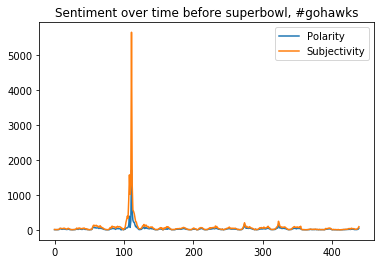

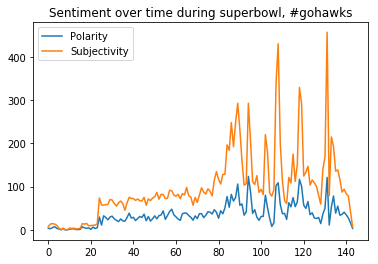

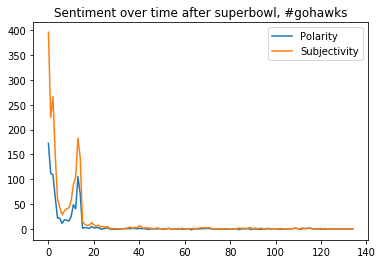

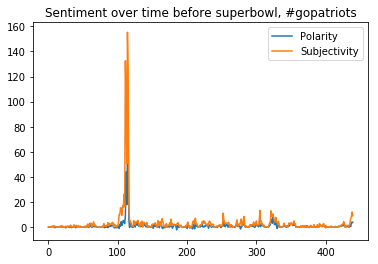

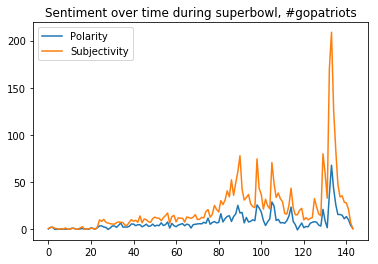

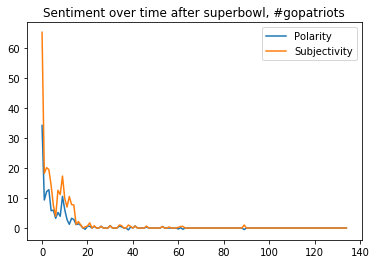

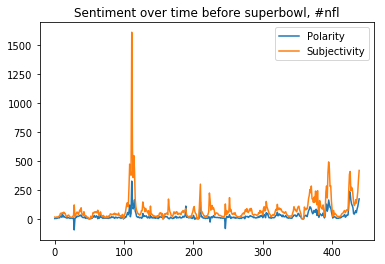

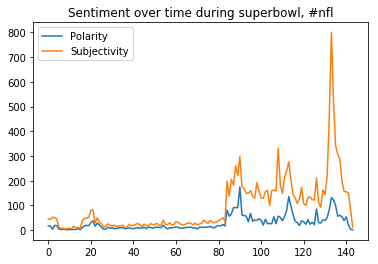

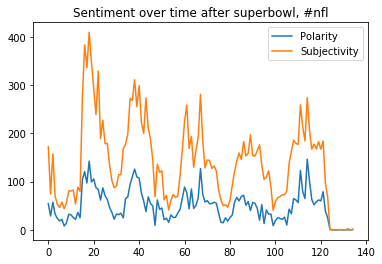

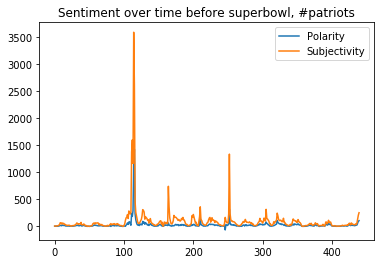

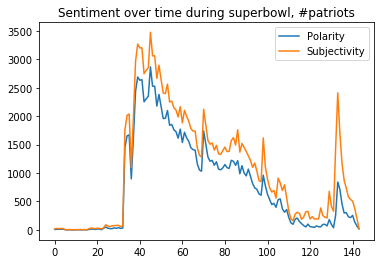

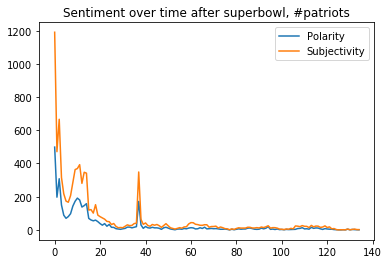

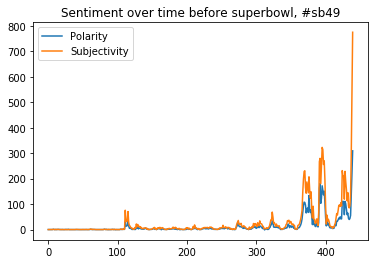

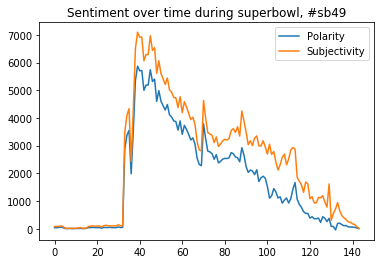

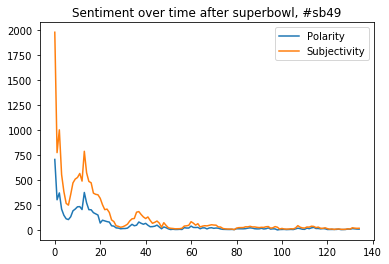

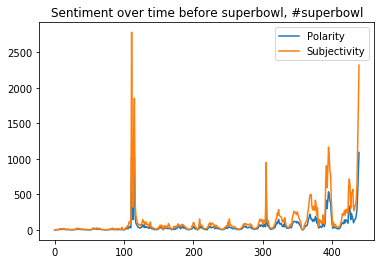

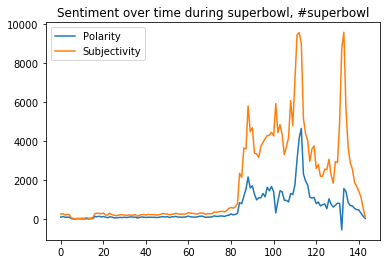

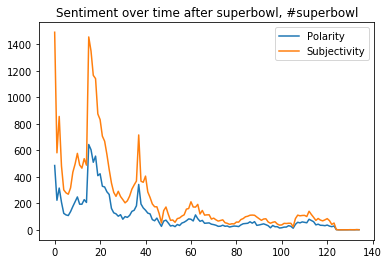

In [221]:
for key in hashtags:
    before = data_hashtag_before[key]
    during = data_hashtag_during[key]
    after = data_hashtag_after[key]
    
    plt.plot(range(before.shape[0]), before[:, 3], label='Polarity')
    plt.plot(range(before.shape[0]), before[:, 4], label='Subjectivity')
    plt.title('Sentiment over time before superbowl, #{}'.format(key))
    plt.legend()
    plt.show()
    
    plt.plot(range(during.shape[0]), during[:, 3], label='Polarity')
    plt.plot(range(during.shape[0]), during[:, 4], label='Subjectivity')
    plt.title('Sentiment over time during superbowl, #{}'.format(key))
    plt.legend()
    plt.show()
    
    plt.plot(range(after.shape[0]), after[:, 3], label='Polarity')
    plt.plot(range(after.shape[0]), after[:, 4], label='Subjectivity')
    plt.title('Sentiment over time after superbowl, #{}'.format(key))
    plt.legend()
    plt.show()

##### Analysis of each time period for aggregated hashtags

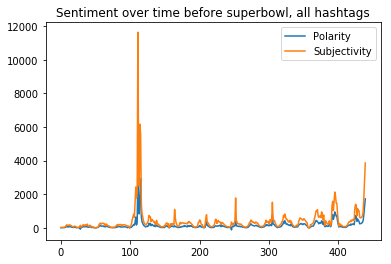

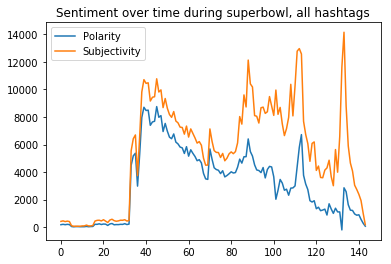

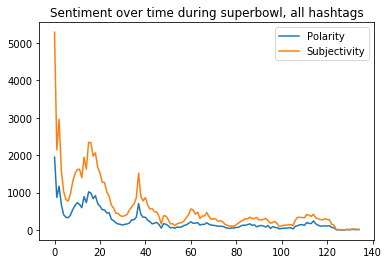

In [222]:
before = data_aggregate_before
during = data_aggregate_during
after = data_aggregate_after

plt.plot(range(before.shape[0]), before[:, 3], label='Polarity')
plt.plot(range(before.shape[0]), before[:, 4], label='Subjectivity')
plt.title('Sentiment over time before superbowl, all hashtags'.format(key))
plt.legend()
plt.show()

plt.plot(range(during.shape[0]), during[:, 3], label='Polarity')
plt.plot(range(during.shape[0]), during[:, 4], label='Subjectivity')
plt.title('Sentiment over time during superbowl, all hashtags'.format(key))
plt.legend()
plt.show()

plt.plot(range(after.shape[0]), after[:, 3], label='Polarity')
plt.plot(range(after.shape[0]), after[:, 4], label='Subjectivity')
plt.title('Sentiment over time during superbowl, all hashtags'.format(key))
plt.legend()
plt.show()

# Linear SGD - predicting possession

#####  Setting up grid search

In [97]:
# Perform GridSearch
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, make_scorer
from sklearn.model_selection import KFold
import time
import pandas as pd

# Just initialize the pipeline with any estimator you like    
pipe = Pipeline(steps=[('estimator', SGDClassifier())])

param_grid = [
    {
        'estimator':[SGDClassifier(random_state=42)],
        'estimator__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'], # classification losses
        'estimator__penalty': ['l2', 'l1', 'elasticnet'],
        'estimator__alpha': [0.0001, 0.001, 0.01],
        'estimator__l1_ratio': [0.15, 0.05, 0.25],
        'estimator__learning_rate': ['optimal'],
        'estimator__tol': [1e-3, 1e-4, 1e-5],
        'estimator__max_iter': [3000, 5000, 10000]
    },
]

In [98]:
def show_results(grid_search_cv, top_results=15):
    if top_results > 0:
        print("Top {} grid search scores on the basis of mean validation accuracy: ".format(top_results))
        means = grid_search_cv.cv_results_['mean_test_score']
        stds = grid_search_cv.cv_results_['std_test_score']
        params = grid_search_cv.cv_results_['params']

        np_rep = np.array([means, stds, params])
        np_rep = np_rep.T

        # sort this array
        sorted_gs = np_rep[(-np_rep[:,0]).argsort()]

        for i in range(top_results):
            mean, std, param = sorted_gs[i]
            print("score:%0.6f (+/-%0.06f) \nparameters:%r" % (mean, std * 2, param))
        print()
    
#     print("Best estimator: ")
#     print(grid_search_cv.best_estimator_)
#     print()

    print("Best cross-val score: ")
    print(grid_search_cv.best_score_)
    print()

#     print("Optimal params: ")
#     print(grid_search_cv.best_params_)
#     print()

##### Parsing data

Breakdown of events from SuperBowl ILIX can be found [here](https://docs.google.com/spreadsheets/d/1f_mKQRS6Hq-wtKKOneouNV8pnT4TUJQ01NMlz_KIGpI/edit?usp=sharing).

In [99]:
possessions_raw = [1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, #HT#,
                   0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

# the bins corresponding to the times each change of possession took place
play_bins = [90, 91, 92, 94, 95, 96, 97, 97, 98, 100, 102, #HTH,
             110, 111, 112, 113, 114, 115, 115, 117, 117, 119, 121, 122]

<span>Resulting list of events:</span> <br>
<span>0 = No gameplay</span> <br>
<span>1 = Seahawks have possession</span> <br>
<span>2 = Patriots have possession</span>

In [100]:
possessions = np.zeros(145)
for idx, b in enumerate(play_bins):
    if idx > 0:
#         print('{}:{} = {}'.format(play_bins[idx-1], b, possessions_raw[idx]))
        possessions[play_bins[idx-1]:b] = possessions_raw[idx] + 1

# 0 = No gameplay
# 1 = Seahawks have possession
# 2 = Patriots have possession
print(possessions)
print(possessions[90:90+32])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 1. 2. 2. 1. 2.
 1. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 2. 1. 2. 2. 2. 2. 2. 1.
 1. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
[2. 1. 2. 2. 1. 2. 1. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 2. 1.
 2. 2. 2. 2. 2. 1. 1. 2.]


### Grid search, every hashtag

In [101]:
poss_hashtag_during = {}

# filter possessions to remove "None" case
poss = possessions[90:90+32]
print(poss.shape)
for key in hashtags:
    poss_hashtag_during[key] = data_hashtag_during[key][90:90+32]
    print(poss_hashtag_during[key].shape)

(32,)
(32, 5)
(32, 5)
(32, 5)
(32, 5)
(32, 5)
(32, 5)


In [102]:
for hashtag in hashtags:
    print('Grid search for {}:'.format(hashtag))
    
    # Define train data and targets
    X = poss_hashtag_during[hashtag]
    y = poss

    X = X.astype(np.float32)
    y = y.astype(np.uint8)

    print('X shape:', X.shape, X.dtype)
    print('y shape:', y.shape, y.dtype)
    
    print('\nPerforming grid search...')

    gs_cv_all = GridSearchCV(pipe, param_grid, cv=KFold(5, shuffle=True), scoring='accuracy',
                             verbose=0, n_jobs=4)
    gs_cv_all.fit(X, y)
    show_results(gs_cv_all, top_results=0)
    
    results = pd.DataFrame(gs_cv_all.cv_results_)
    results.to_csv('gs_q16_{}_2.csv'.format(hashtag))
#     results.sort_values('mean_test_score', ascending=False).iloc[:, 0:15]
    
    print('='*60)
    print()

Grid search for gohawks:
X shape: (32, 5) float32
y shape: (32,) uint8

Performing grid search...
Best cross-val score: 
0.65625


Grid search for gopatriots:
X shape: (32, 5) float32
y shape: (32,) uint8

Performing grid search...
Best cross-val score: 
0.625


Grid search for nfl:
X shape: (32, 5) float32
y shape: (32,) uint8

Performing grid search...
Best cross-val score: 
0.5625


Grid search for patriots:
X shape: (32, 5) float32
y shape: (32,) uint8

Performing grid search...
Best cross-val score: 
0.59375


Grid search for sb49:
X shape: (32, 5) float32
y shape: (32,) uint8

Performing grid search...
Best cross-val score: 
0.75


Grid search for superbowl:
X shape: (32, 5) float32
y shape: (32,) uint8

Performing grid search...
Best cross-val score: 
0.4375




### Grid search, aggregated sentiment

In [229]:
poss_aggregate_during = {}

# filter possessions to remove "None" case
poss = possessions[90:90+32]
print(poss.shape)
poss_aggregate_during = data_aggregate_during[90:90+32]
print(poss_aggregate_during.shape)

(32,)
(32, 5)


In [230]:
print('Grid search for aggregated sentiment:')
    
# Define train data and targets
X = poss_aggregate_during
y = poss

X = X.astype(np.float32)
y = y.astype(np.uint8)

print('X shape:', X.shape, X.dtype)
print('y shape:', y.shape, y.dtype)

print('\nPerforming grid search...')

gs_cv_all = GridSearchCV(pipe, param_grid, cv=KFold(5, shuffle=True), scoring='accuracy',
                         verbose=0, n_jobs=4)
gs_cv_all.fit(X, y)
show_results(gs_cv_all, top_results=0)

print('='*60)
print()

Grid search for aggregated sentiment:
X shape: (32, 5) float32
y shape: (32,) uint8

Performing grid search...
Best cross-val score: 
0.625




# LSTM - predicting possession

Breakdown of events from SuperBowl ILIX can be found [here](https://docs.google.com/spreadsheets/d/1f_mKQRS6Hq-wtKKOneouNV8pnT4TUJQ01NMlz_KIGpI/edit?usp=sharing).

In [17]:
possessions_raw = [1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, #HT#,
                   0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

# the bins corresponding to the times each change of possession took place
play_bins = [90, 91, 92, 94, 95, 96, 97, 97, 98, 100, 102, #HTH,
             110, 111, 112, 113, 114, 115, 115, 117, 117, 119, 121, 122]

<span>Resulting list of events:</span> <br>
<span>0 = No gameplay</span> <br>
<span>1 = Seahawks have possession</span> <br>
<span>2 = Patriots have possession</span>

In [18]:
possessions = np.zeros(145)
for idx, b in enumerate(play_bins):
    if idx > 0:
#         print('{}:{} = {}'.format(play_bins[idx-1], b, possessions_raw[idx]))
        possessions[play_bins[idx-1]:b] = possessions_raw[idx] + 1

# 0 = No gameplay
# 1 = Seahawks have possession
# 2 = Patriots have possession
print(possessions)
print(possessions[90:90+32])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 1. 2. 2. 1. 2.
 1. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 2. 1. 2. 2. 2. 2. 2. 1.
 1. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
[2. 1. 2. 2. 1. 2. 1. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 2. 1.
 2. 2. 2. 2. 2. 1. 1. 2.]


##### Sliding window approach

In [87]:
width = 32
window = 4
pad = 1
stride = 1

output_width = int((width - window + 2*pad)/stride + 1)
print("Output width:", output_width)

Output width: 31


In [88]:
poss_hashtag_during = {}

# filter possessions to remove "None" case
poss = possessions[90+(window-1-2*pad):90+32]
print(poss.shape)
for key in hashtags:
    poss_hashtag_during[key] = data_hashtag_during[key][90-pad:90+32+pad]
    print(poss_hashtag_during[key].shape)

(31,)
(34, 5)
(34, 5)
(34, 5)
(34, 5)
(34, 5)
(34, 5)


In [89]:
poss_hashtag_padded = poss_hashtag_during

# for key in hashtags:
#     poss_hashtag_padded[key] = np.pad(poss_hashtag_during[key], ((pad,),(0,)), 'constant', constant_values=0)
    
# window everything
poss_hashtag_windowed = {}

for key in hashtags:
    windowed = np.zeros((output_width, window, poss_hashtag_padded[key].shape[1]))
    
    # window the sentiment values:
    for w in range(output_width):
        windowed[w] = poss_hashtag_padded[key][w:w+window,:]
        
    poss_hashtag_windowed[key] = windowed
    print(poss_hashtag_windowed[key].shape)

(31, 4, 5)
(31, 4, 5)
(31, 4, 5)
(31, 4, 5)
(31, 4, 5)
(31, 4, 5)


In [90]:
all_hashtag_windows = np.concatenate([poss_hashtag_windowed[k] for k in hashtags], axis=0)
print(all_hashtag_windows.shape)

# repeat possession values
all_poss = np.array([poss for _ in hashtags]).ravel()
print(all_poss.shape)

(186, 4, 5)
(186,)


### LSTM model

In [91]:
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend

In [92]:
backend.clear_session()

In [93]:
X_train, X_val, y_train, y_val = train_test_split(all_hashtag_windows, all_poss-1, test_size=0, random_state=42)

In [94]:
learning_rate = 1e-5

model1 = tf.keras.Sequential()
model1.add(layers.LSTM(20, input_shape=(all_hashtag_windows.shape[1], all_hashtag_windows.shape[2])))
model1.add(layers.Dense(units=50))
model1.add(layers.Dropout(0.1))
model1.add(layers.Dense(units=2, activation=tf.nn.softmax))
opt = tf.train.AdamOptimizer(learning_rate)

model1.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                2080      
_________________________________________________________________
dense (Dense)                (None, 50)                1050      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 102       
Total params: 3,232
Trainable params: 3,232
Non-trainable params: 0
_________________________________________________________________


In [95]:
history1 = model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=25)

Train on 186 samples, validate on 0 samples
Epoch 1/500
186/186 [==============================] - ETA: 5s - loss: 0.6984 - acc: 0.560 - ETA: 0s - loss: 0.6595 - acc: 0.640 - 1s 5ms/step - loss: 0.6832 - acc: 0.5753
Epoch 2/500
186/186 [==============================] - ETA: 0s - loss: 0.6902 - acc: 0.560 - ETA: 0s - loss: 0.6775 - acc: 0.593 - 0s 527us/step - loss: 0.6855 - acc: 0.5699
Epoch 3/500
186/186 [==============================] - ETA: 0s - loss: 0.6925 - acc: 0.560 - ETA: 0s - loss: 0.6921 - acc: 0.566 - 0s 511us/step - loss: 0.6856 - acc: 0.5860
Epoch 4/500
186/186 [==============================] - ETA: 0s - loss: 0.6771 - acc: 0.560 - ETA: 0s - loss: 0.6779 - acc: 0.573 - 0s 527us/step - loss: 0.6713 - acc: 0.5860
Epoch 5/500
186/186 [==============================] - ETA: 0s - loss: 0.6999 - acc: 0.560 - ETA: 0s - loss: 0.6773 - acc: 0.586 - 0s 516us/step - loss: 0.6813 - acc: 0.5753
Epoch 6/500
186/186 [==============================] - ETA: 0s - loss: 0.6672 - acc: 0.6

Epoch 94/500
186/186 [==============================] - ETA: 0s - loss: 0.7263 - acc: 0.360 - ETA: 0s - loss: 0.6800 - acc: 0.553 - 0s 495us/step - loss: 0.6793 - acc: 0.5645
Epoch 95/500
186/186 [==============================] - ETA: 0s - loss: 0.6560 - acc: 0.640 - ETA: 0s - loss: 0.6828 - acc: 0.600 - 0s 495us/step - loss: 0.6846 - acc: 0.5860
Epoch 96/500
186/186 [==============================] - ETA: 0s - loss: 0.7179 - acc: 0.520 - ETA: 0s - loss: 0.6918 - acc: 0.573 - 0s 500us/step - loss: 0.6908 - acc: 0.5753
Epoch 97/500
186/186 [==============================] - ETA: 0s - loss: 0.6825 - acc: 0.560 - ETA: 0s - loss: 0.6737 - acc: 0.580 - 0s 522us/step - loss: 0.6717 - acc: 0.5806
Epoch 98/500
186/186 [==============================] - ETA: 0s - loss: 0.7252 - acc: 0.480 - ETA: 0s - loss: 0.6727 - acc: 0.580 - 0s 506us/step - loss: 0.6786 - acc: 0.5753
Epoch 99/500
186/186 [==============================] - ETA: 0s - loss: 0.7189 - acc: 0.480 - ETA: 0s - loss: 0.6810 - acc: 0

186/186 [==============================] - ETA: 0s - loss: 0.7342 - acc: 0.440 - ETA: 0s - loss: 0.6832 - acc: 0.553 - 0s 527us/step - loss: 0.6816 - acc: 0.5699
Epoch 187/500
186/186 [==============================] - ETA: 0s - loss: 0.6134 - acc: 0.800 - ETA: 0s - loss: 0.6818 - acc: 0.580 - 0s 500us/step - loss: 0.6848 - acc: 0.5699
Epoch 188/500
186/186 [==============================] - ETA: 0s - loss: 0.6737 - acc: 0.600 - ETA: 0s - loss: 0.6818 - acc: 0.586 - 0s 500us/step - loss: 0.6797 - acc: 0.5806
Epoch 189/500
186/186 [==============================] - ETA: 0s - loss: 0.6700 - acc: 0.640 - ETA: 0s - loss: 0.6760 - acc: 0.606 - 0s 495us/step - loss: 0.6764 - acc: 0.5968
Epoch 190/500
186/186 [==============================] - ETA: 0s - loss: 0.7590 - acc: 0.400 - ETA: 0s - loss: 0.6847 - acc: 0.560 - 0s 500us/step - loss: 0.6812 - acc: 0.5753
Epoch 191/500
186/186 [==============================] - ETA: 0s - loss: 0.6707 - acc: 0.640 - ETA: 0s - loss: 0.6814 - acc: 0.593 - 0

186/186 [==============================] - ETA: 0s - loss: 0.6833 - acc: 0.520 - ETA: 0s - loss: 0.6834 - acc: 0.560 - 0s 554us/step - loss: 0.6797 - acc: 0.5645
Epoch 279/500
186/186 [==============================] - ETA: 0s - loss: 0.6996 - acc: 0.520 - ETA: 0s - loss: 0.6697 - acc: 0.580 - 0s 532us/step - loss: 0.6738 - acc: 0.5645
Epoch 280/500
186/186 [==============================] - ETA: 0s - loss: 0.6802 - acc: 0.600 - ETA: 0s - loss: 0.6823 - acc: 0.593 - 0s 522us/step - loss: 0.6859 - acc: 0.5806
Epoch 281/500
186/186 [==============================] - ETA: 0s - loss: 0.7117 - acc: 0.520 - ETA: 0s - loss: 0.6847 - acc: 0.586 - 0s 511us/step - loss: 0.6826 - acc: 0.5860
Epoch 282/500
186/186 [==============================] - ETA: 0s - loss: 0.7544 - acc: 0.360 - ETA: 0s - loss: 0.6818 - acc: 0.560 - 0s 516us/step - loss: 0.6763 - acc: 0.5753
Epoch 283/500
186/186 [==============================] - ETA: 0s - loss: 0.7183 - acc: 0.480 - ETA: 0s - loss: 0.6950 - acc: 0.566 - 0

186/186 [==============================] - ETA: 0s - loss: 0.7008 - acc: 0.520 - ETA: 0s - loss: 0.6856 - acc: 0.566 - 0s 516us/step - loss: 0.6823 - acc: 0.5699
Epoch 371/500
186/186 [==============================] - ETA: 0s - loss: 0.6465 - acc: 0.680 - ETA: 0s - loss: 0.6755 - acc: 0.606 - 0s 527us/step - loss: 0.6844 - acc: 0.5860
Epoch 372/500
186/186 [==============================] - ETA: 0s - loss: 0.6666 - acc: 0.640 - ETA: 0s - loss: 0.6943 - acc: 0.580 - 0s 500us/step - loss: 0.6933 - acc: 0.5806
Epoch 373/500
186/186 [==============================] - ETA: 0s - loss: 0.7033 - acc: 0.560 - ETA: 0s - loss: 0.6951 - acc: 0.546 - 0s 505us/step - loss: 0.6819 - acc: 0.5806
Epoch 374/500
186/186 [==============================] - ETA: 0s - loss: 0.6645 - acc: 0.600 - ETA: 0s - loss: 0.6733 - acc: 0.580 - 0s 500us/step - loss: 0.6757 - acc: 0.5753
Epoch 375/500
186/186 [==============================] - ETA: 0s - loss: 0.6585 - acc: 0.560 - ETA: 0s - loss: 0.6664 - acc: 0.600 - 0

186/186 [==============================] - ETA: 0s - loss: 0.6425 - acc: 0.640 - ETA: 0s - loss: 0.6696 - acc: 0.586 - 0s 511us/step - loss: 0.6753 - acc: 0.5860
Epoch 463/500
186/186 [==============================] - ETA: 0s - loss: 0.6438 - acc: 0.640 - ETA: 0s - loss: 0.6738 - acc: 0.593 - 0s 511us/step - loss: 0.6862 - acc: 0.5699
Epoch 464/500
186/186 [==============================] - ETA: 0s - loss: 0.7253 - acc: 0.400 - ETA: 0s - loss: 0.6965 - acc: 0.553 - 0s 511us/step - loss: 0.6892 - acc: 0.5645
Epoch 465/500
186/186 [==============================] - ETA: 0s - loss: 0.6836 - acc: 0.560 - ETA: 0s - loss: 0.6867 - acc: 0.560 - 0s 522us/step - loss: 0.6814 - acc: 0.5806
Epoch 466/500
186/186 [==============================] - ETA: 0s - loss: 0.6772 - acc: 0.600 - ETA: 0s - loss: 0.6795 - acc: 0.606 - 0s 511us/step - loss: 0.6839 - acc: 0.5860
Epoch 467/500
186/186 [==============================] - ETA: 0s - loss: 0.6580 - acc: 0.640 - ETA: 0s - loss: 0.6730 - acc: 0.600 - 0

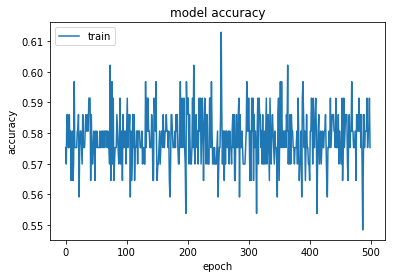

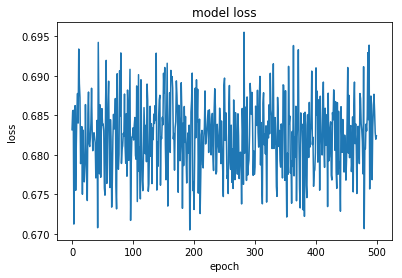

In [96]:
# summarize history for accuracy
plt.plot(history1.history['acc'])
# plt.plot(history1.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
plt.legend(['train'], loc='upper left')
plt.show()

# # summarize history for loss
plt.plot(history1.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()